<a href="https://colab.research.google.com/github/NadeemQazi/Helloword/blob/master/SparkMLdiabetesStepByStep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# every package has to install each time googlecolab runs jyputernoot book.
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://www-eu.apache.org/dist/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"
# starts the spark only three steps
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()




In [0]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#raw_data = spark.read.format("csv").option("header","true").option("inferSchema", "true").load(r".\\diabetes.csv")
dataset = spark.read.csv('drive/My Drive/Colab Notebooks/diabetes.csv',inferSchema=True, header =True)

In [5]:
# what are the columns in this dataset
dataset.columns

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age',
 'Outcome']

In [6]:
dataset.describe().select("Summary","Pregnancies","Glucose","BloodPressure").show()

+-------+------------------+-----------------+------------------+
|Summary|       Pregnancies|          Glucose|     BloodPressure|
+-------+------------------+-----------------+------------------+
|  count|               768|              768|               768|
|   mean|3.8450520833333335|     120.89453125|       69.10546875|
| stddev|  3.36957806269887|31.97261819513622|19.355807170644777|
|    min|                 0|                0|                 0|
|    max|                17|              199|               122|
+-------+------------------+-----------------+------------------+



In [7]:
dataset.describe().select("Summary","SkinThickness","Insulin").show()

+-------+------------------+------------------+
|Summary|     SkinThickness|           Insulin|
+-------+------------------+------------------+
|  count|               768|               768|
|   mean|20.536458333333332| 79.79947916666667|
| stddev|15.952217567727642|115.24400235133803|
|    min|                 0|                 0|
|    max|                99|               846|
+-------+------------------+------------------+



In [8]:
dataset.describe().select("Summary","BMI","DiabetesPedigreeFunction","Age").show()

+-------+------------------+------------------------+------------------+
|Summary|               BMI|DiabetesPedigreeFunction|               Age|
+-------+------------------+------------------------+------------------+
|  count|               768|                     768|               768|
|   mean|31.992578124999977|      0.4718763020833327|33.240885416666664|
| stddev| 7.884160320375441|       0.331328595012775|11.760231540678689|
|    min|               0.0|                   0.078|                21|
|    max|              67.1|                    2.42|                81|
+-------+------------------+------------------------+------------------+



In [10]:
# replace min value of zeros with Nan as data cleaning processs
import numpy as np
from pyspark.sql.functions import when
dataset=dataset.withColumn("Glucose",when(dataset.Glucose==0,np.nan).otherwise (dataset.Glucose))
dataset=dataset.withColumn("BloodPressure",when(dataset.BloodPressure==0,np.nan).otherwise(dataset.BloodPressure))
dataset=dataset.withColumn("SkinThickness",when(dataset.SkinThickness==0,np.nan).otherwise(dataset.SkinThickness))
dataset=dataset.withColumn("BMI",when(dataset.BMI==0,np.nan).otherwise(dataset.BMI))
dataset=dataset.withColumn("Insulin",when(dataset.Insulin==0,np.nan).otherwise(dataset.Insulin))
dataset.select("Insulin","Glucose","BloodPressure","SkinThickness","BMI").show(5)


+-------+-------+-------------+-------------+----+
|Insulin|Glucose|BloodPressure|SkinThickness| BMI|
+-------+-------+-------------+-------------+----+
|    NaN|  148.0|         72.0|         35.0|33.6|
|    NaN|   85.0|         66.0|         29.0|26.6|
|    NaN|  183.0|         64.0|          NaN|23.3|
|   94.0|   89.0|         66.0|         23.0|28.1|
|  168.0|  137.0|         40.0|         35.0|43.1|
+-------+-------+-------------+-------------+----+
only showing top 5 rows



In [11]:
#impute
from pyspark.ml.feature import Imputer
imputer=Imputer(inputCols=["Glucose","BloodPressure","SkinThickness","BMI","Insulin"],outputCols=["Glucose","BloodPressure","SkinThickness","BMI","Insulin"])
model=imputer.fit(dataset)
dataset=model.transform(dataset)
dataset.show(5)

+-----------+-------+-------------+------------------+-----------------+----+------------------------+---+-------+
|Pregnancies|Glucose|BloodPressure|     SkinThickness|          Insulin| BMI|DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-------------+------------------+-----------------+----+------------------------+---+-------+
|          6|  148.0|         72.0|              35.0|155.5482233502538|33.6|                   0.627| 50|      1|
|          1|   85.0|         66.0|              29.0|155.5482233502538|26.6|                   0.351| 31|      0|
|          8|  183.0|         64.0|29.153419593345657|155.5482233502538|23.3|                   0.672| 32|      1|
|          1|   89.0|         66.0|              23.0|             94.0|28.1|                   0.167| 21|      0|
|          0|  137.0|         40.0|              35.0|            168.0|43.1|                   2.288| 33|      1|
+-----------+-------+-------------+------------------+-----------------+----+---

In [12]:
#us combine all the features in one single feature vector.
cols=dataset.columns
cols.remove("Outcome")
# Let us import the vector assembler
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=cols,outputCol="features")
# Now let us use the transform method to transform our dataset
dataset=assembler.transform(dataset)
dataset.select("features").show(truncate=False)

+-----------------------------------------------------------------------------------+
|features                                                                           |
+-----------------------------------------------------------------------------------+
|[6.0,148.0,72.0,35.0,155.5482233502538,33.6,0.627,50.0]                            |
|[1.0,85.0,66.0,29.0,155.5482233502538,26.6,0.351,31.0]                             |
|[8.0,183.0,64.0,29.153419593345657,155.5482233502538,23.3,0.672,32.0]              |
|[1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0]                                          |
|[0.0,137.0,40.0,35.0,168.0,43.1,2.288,33.0]                                        |
|[5.0,116.0,74.0,29.153419593345657,155.5482233502538,25.6,0.201,30.0]              |
|[3.0,78.0,50.0,32.0,88.0,31.0,0.248,26.0]                                          |
|[10.0,115.0,72.40518417462484,29.153419593345657,155.5482233502538,35.3,0.134,29.0]|
|[2.0,197.0,70.0,45.0,543.0,30.5,0.158,53.0]          

In [13]:
#Standard Sclarizer
from pyspark.ml.feature import StandardScaler
standardscaler=StandardScaler().setInputCol("features").setOutputCol("Scaled_features")
dataset=standardscaler.fit(dataset).transform(dataset)
dataset.select("features","Scaled_features").show(5)

+--------------------+--------------------+
|            features|     Scaled_features|
+--------------------+--------------------+
|[6.0,148.0,72.0,3...|[1.78063837321943...|
|[1.0,85.0,66.0,29...|[0.29677306220323...|
|[8.0,183.0,64.0,2...|[2.37418449762590...|
|[1.0,89.0,66.0,23...|[0.29677306220323...|
|[0.0,137.0,40.0,3...|[0.0,4.5012560836...|
+--------------------+--------------------+
only showing top 5 rows



In [0]:
#Train, test split
train, test = dataset.randomSplit([0.8, 0.2], seed=12345)

In [15]:
 #imbalance in the dataset
 dataset_size=float(train.select("Outcome").count())
numPositives=train.select("Outcome").where('Outcome == 1').count()
per_ones=(float(numPositives)/float(dataset_size))*100
numNegatives=float(dataset_size-numPositives)
print('The number of ones are {}'.format(numPositives))
print('Percentage of ones are {}'.format(per_ones))

The number of ones are 206
Percentage of ones are 34.27620632279534


In [16]:
BalancingRatio= numNegatives/dataset_size
print('BalancingRatio = {}'.format(BalancingRatio))

BalancingRatio = 0.6572379367720466


In [17]:
# balance 
train=train.withColumn("classWeights", when(train.Outcome == 1,BalancingRatio).otherwise(1-BalancingRatio))
train.select("classWeights").show(5)

+-------------------+
|       classWeights|
+-------------------+
|0.34276206322795344|
|0.34276206322795344|
|0.34276206322795344|
|0.34276206322795344|
|0.34276206322795344|
+-------------------+
only showing top 5 rows



In [18]:
 #Feature selection
# Feature selection using chisquareSelector
from pyspark.ml.feature import ChiSqSelector
css = ChiSqSelector(featuresCol='Scaled_features',outputCol='Aspect',labelCol='Outcome',fpr=0.05)
train=css.fit(train).transform(train)
test=css.fit(test).transform(test)
test.select("Aspect").show(5,truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------+
|Aspect                                                                                                                                 |
+---------------------------------------------------------------------------------------------------------------------------------------+
|[0.0,2.562758938133151,7.274924068899646,3.29885013976358,0.47047140468429116,5.367154589366346,1.3098778871870878,1.785679127775751]  |
|[0.0,2.8256060087109103,5.621532235058818,3.640110499049468,1.8295247783934943,5.207158111092553,0.7183201316832416,2.125808485447323] |
|[0.0,2.9898854278220095,5.621532235058818,3.640110499049468,2.4699748745925287,5.8035086210221465,1.1499158410559458,2.125808485447323]|
|[0.0,3.1213089631108892,5.290853868290652,4.436384670716539,1.2349874372962644,6.487129937282901,1.1046435638490186,1.870711467193644] |
|[0.0,3.1213089631108892,6.6135673

In [19]:
#Building a classification model using Logistic Regression (LR)
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(labelCol="Outcome", featuresCol="Aspect",weightCol="classWeights",maxIter=10)
model=lr.fit(train)
predict_train=model.transform(train)
predict_test=model.transform(test)
predict_test.select("Outcome","prediction").show(10)

+-------+----------+
|Outcome|prediction|
+-------+----------+
|      0|       0.0|
|      0|       0.0|
|      0|       0.0|
|      0|       0.0|
|      0|       0.0|
|      1|       0.0|
|      0|       0.0|
|      0|       0.0|
|      0|       0.0|
|      0|       1.0|
+-------+----------+
only showing top 10 rows



In [20]:
#Evaluating the model
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator=BinaryClassificationEvaluator(rawPredictionCol="rawPrediction",labelCol="Outcome")
predict_test.select("Outcome","rawPrediction","prediction","probability").show(5)

+-------+--------------------+----------+--------------------+
|Outcome|       rawPrediction|prediction|         probability|
+-------+--------------------+----------+--------------------+
|      0|[2.58888023648551...|       0.0|[0.93014249279728...|
|      0|[2.32098145085482...|       0.0|[0.91059987057264...|
|      0|[1.68081620680194...|       0.0|[0.84301258010142...|
|      0|[0.64946166218389...|       0.0|[0.65688913922505...|
|      0|[1.78997774283908...|       0.0|[0.85692454770533...|
+-------+--------------------+----------+--------------------+
only showing top 5 rows



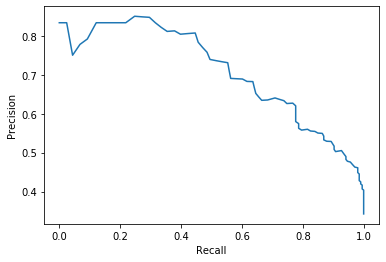

In [21]:
print(model.summary)
import matplotlib.pyplot as plt
pr = model.summary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()